# Unitary AQC demo

## Step 1: Map to quantum circuit and operator

### Tell jax to use double precision (64-bit) floats

This must be done before jax is used; otherwise it defaults to 32-bit floats (single precision).  See https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

### Construct Hamiltonian

In [2]:
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from rustworkx.generators import path_graph

coupling_map = path_graph(8)

hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)

### Generate a single Trotter step of the target circuit

This single Trotter step circuit will be repeated 256 times:


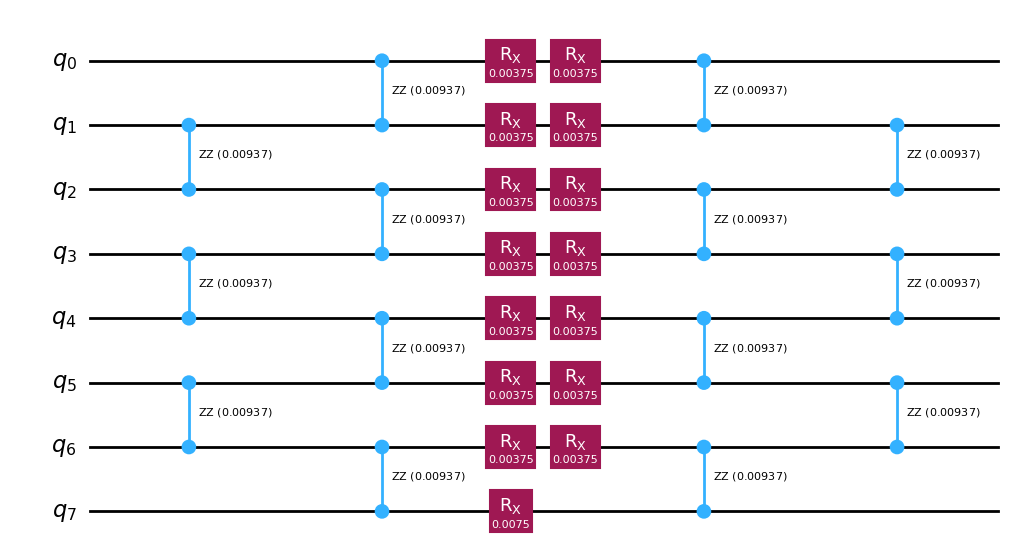

In [3]:
aqc_evolution_time = 2.4
aqc_target_log2_num_trotter_steps = 8

aqc_target_step_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit.draw("mpl", fold=-1)

### Construct a good circuit, with fewer Trotter steps than the target

In [4]:
ansatz_num_trotter_steps = 2

aqc_good_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)

### Generate an ansatz from the good circuit

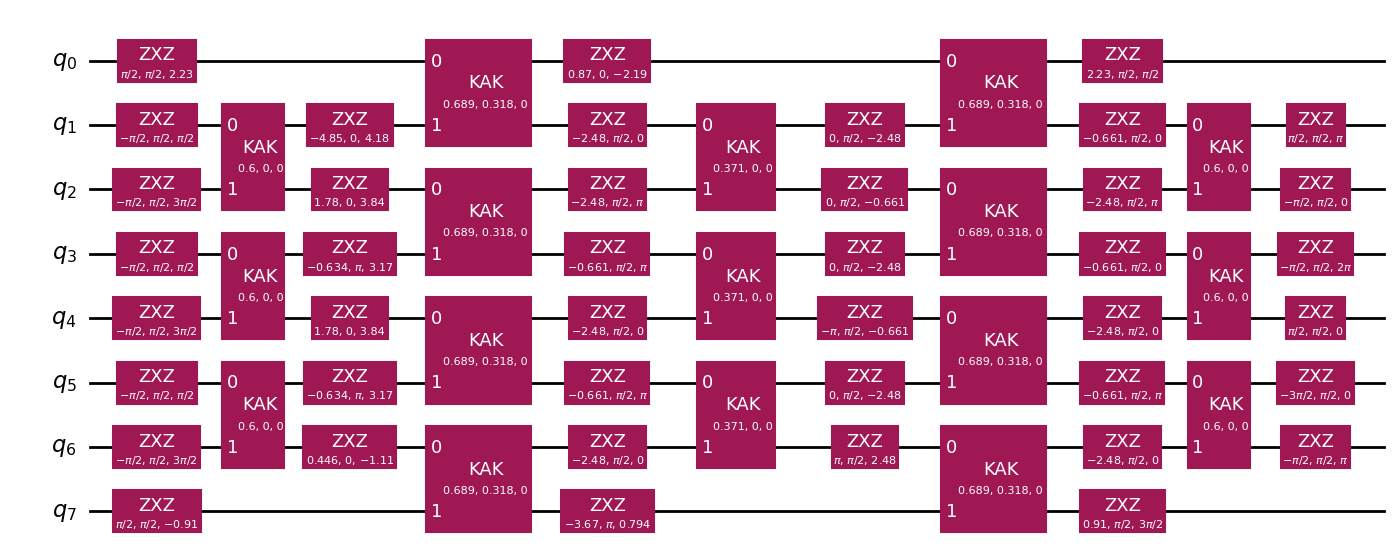

In [5]:
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit, parameter_name="x"
)
aqc_ansatz.assign_parameters(aqc_initial_parameters).draw("mpl", fold=-1)

### Set up quimb

Note that we use `quimb.tensor.Circuit` here, not `CircuitMPS`.

In [6]:
from functools import partial

import quimb.tensor

from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(partial(quimb.tensor.Circuit), autodiff_backend="jax")

### Obtain the tensor network of the single Trotter step of the target circuit

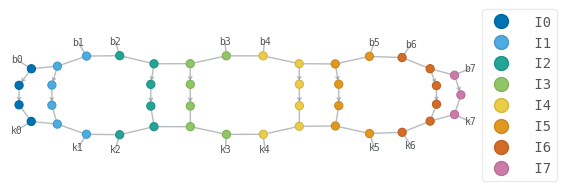

In [7]:
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo = tensornetwork_from_circuit(aqc_target_step_circuit, simulator_settings).get_uni()
aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

### Fuse multibonds to form a matrix-product operator (MPO)

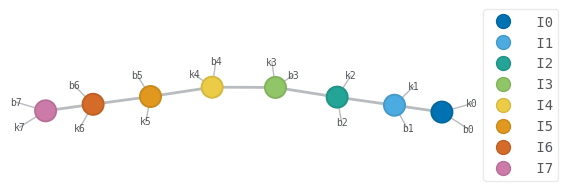

In [8]:
for site in aqc_target_mpo.site_tags:
    aqc_target_mpo ^= site
aqc_target_mpo.fuse_multibonds_()

aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

### Cast it to `quimb.tensor.MatrixProductOperator` and compress

In [9]:
cutoff = 1e-8

aqc_target_mpo.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo.compress(cutoff=cutoff)
aqc_target_mpo.show()

│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │


### Repeatedly square and compress the MPO, so that it represents an operator with many Trotter steps

In [10]:
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo = aqc_target_mpo.apply(aqc_target_mpo)
    aqc_target_mpo.compress(cutoff=cutoff)
    aqc_target_mpo.show()
aqc_target_mpo

│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │
│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │
│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │
│3│3│3│3│3│3│3│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │
│4│4│4│4│4│4│4│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │
│4│6│6│6│6│6│4│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │
│4│8│8│8│8│8│4│
●─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │
│4│16│20│20│20│16│4│
●─<──<──<──<──<──<─<
│ │  │  │  │  │  │ │


MatrixProductOperator(tensors=8, indices=23, L=8, max_bond=20)

### Perform optimization using `MaximizeUnitaryFidelity` objective

In [11]:
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

objective = MaximizeUnitaryFidelity(aqc_target_mpo, aqc_ansatz, simulator_settings)

stopping_point = 1e-4


def my_loss_function(*args):
    val, grad = objective.loss_function(*args)
    print(f"Evaluating loss function: {1 - val:.8}")
    return val, grad


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    my_loss_function,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Evaluating loss function: 0.46658826
Evaluating loss function: 0.75925664
Intermediate result: Fidelity 0.75925664
Evaluating loss function: 0.87112154
Intermediate result: Fidelity 0.87112154
Evaluating loss function: 0.94314829
Intermediate result: Fidelity 0.94314829
Evaluating loss function: 0.98021114
Intermediate result: Fidelity 0.98021114
Evaluating loss function: 0.98868579
Intermediate result: Fidelity 0.98868579
Evaluating loss function: 0.99080511
Intermediate result: Fidelity 0.99080511
Evaluating loss function: 0.99227904
Intermediate result: Fidelity 0.99227904
Evaluating loss function: 0.99444617
Intermediate result: Fidelity 0.99444617
Evaluating loss function: 0.9948181
Intermediate result: Fidelity 0.9948181
Evaluating loss function: 0.99548705
Intermediate result: Fidelity 0.99548705
Evaluating loss function: 0.99558522
Intermediate result: Fidelity 0.99558522
Evaluating loss function: 0.99576326
Intermediate result: Fidelity 0.99576326
Evaluating loss function: 0.9

### Form the optimized circuit

In [12]:
aqc_optimized_block = aqc_ansatz.assign_parameters(aqc_final_parameters)

### Calculate the process fidelity if few qubits

In [13]:
from qiskit.quantum_info import Operator, process_fidelity

if coupling_map.num_nodes() <= 8:
    target_operator = Operator(aqc_target_step_circuit).power(2**aqc_target_log2_num_trotter_steps)

    initial_fidelity = process_fidelity(
        Operator(aqc_good_circuit),
        target_operator,
    )
    print(f"Initial process fidelity: {initial_fidelity:.8}")

    final_fidelity = process_fidelity(
        Operator(aqc_optimized_block),
        target_operator,
    )
    print(f"Final process fidelity: {final_fidelity:.8}")

Initial process fidelity: 0.217973
Final process fidelity: 0.99770414


### Calcuate Hilbert-Schmidt inner product if few qubits

In [14]:
import numpy as np

if coupling_map.num_nodes() <= 8:
    initial_fidelity = abs(
        np.trace(Operator(aqc_good_circuit).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Hilbert-Schmidt inner product: {initial_fidelity:.8}")

    final_fidelity = abs(
        np.trace(
            Operator(aqc_optimized_block).conjugate().to_matrix() @ target_operator.to_matrix()
        )
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Hilbert-Schmidt inner product: {final_fidelity:.8}")

Initial Hilbert-Schmidt inner product: 0.46687579
Final Hilbert-Schmidt inner product: 0.99885141


NOTE: When this notebook is run on a small number of qubits, it is apparent that Qiskit's [`process_fidelity`](https://docs.quantum.ibm.com/api/qiskit/quantum_info#qiskit.quantum_info.process_fidelity) function does not calculate the same quantity as the loss function.

Hence, the `MaximizeUnitaryFidelity` objective is really misnamed above.  It should be `MinimizeUnitaryDistance` or `MaximizeHilbertSchmidtInnerProduct` or similar.

Compare any proposed name to the existing cost function, `MaximizeStateFidelity`, used for initial state AQC.

One possibility would be to use the names `TargetState` and `TargetUnitary`, instead, in place of `MaximizeStateFidelity` and `MaximizeUnitaryFidelity`.

### Form final circuit by repeating the block

The final circuit implements evolution of the Hamiltonian for time = 9.6.


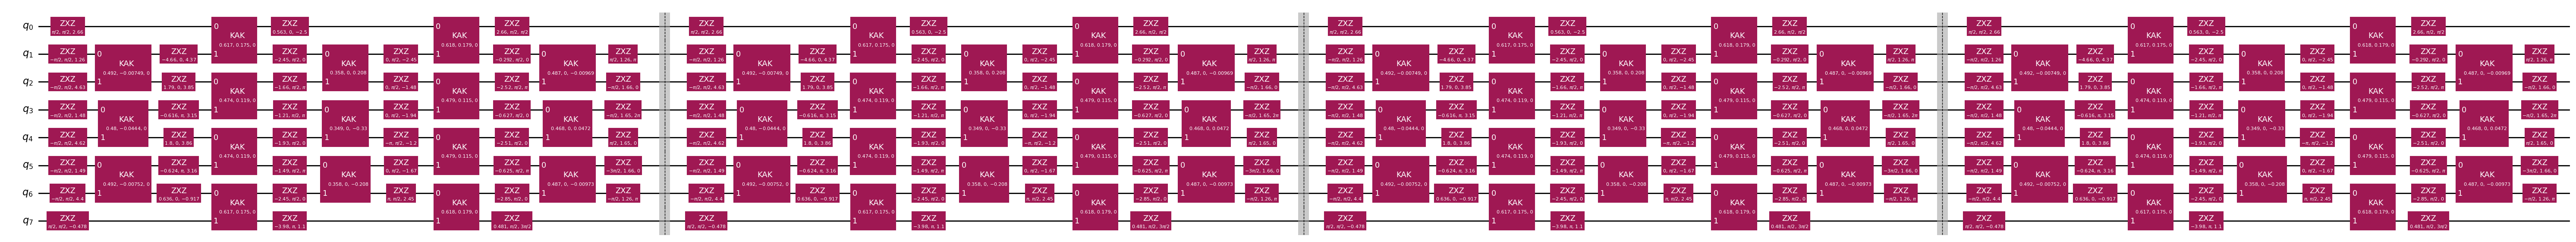

In [15]:
num_repeats = 4

print(
    f"The final circuit implements evolution of the Hamiltonian for time = {num_repeats * aqc_evolution_time}."
)  # FIXME: can i say anything about the fidelity??  ignoring cutoff/roundoff error of course
final_circuit = aqc_optimized_block.repeat(num_repeats)

aqc_optimized_block.repeat(num_repeats, insert_barriers=True).decompose().draw("mpl", fold=-1)

## Step 2: Transpile for execution on target hardware

more to come...